In [1]:
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import time 
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.model_selection import train_test_split

import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import pickle
from ngboost import NGBClassifier

In [2]:
# Visualisation class
class Visualization:
    
    labels=["Normal","Anomaly"]
    
    def drow_confusion_matrix(self,y,ypred):
        matrix=confusion_matrix(y,ypred)
        plt.figure(figsize=(15,10))
        colors=["indianred","lightseagreen"]
        sns.heatmap(matrix,xticklabels=self.labels,yticklabels=self.labels,cmap=colors,annot=True,fmt="d")
        plt.title("confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel("Predicted")
        plt.show()
    
    
    def drow_anomaly(self,y,error,threshold):
        groupsDF=pd.DataFrame({
            "error":error,
            "true":y
        }).groupby("true")
        
        figure , axes= plt.subplots(figsize=(12,8))
        for name,group in groupsDF:
            axes.plot(
                      group.index,group.error,marker="x" if name == 1 else "o",linestyle='',
                      color='r' if name==1 else "teal" , label="Anomaly" if name==1 else "Normal"
                     )
            
        axes.hlines(threshold,axes.get_xlim()[0],axes.get_xlim()[1],color="b",zorder=100,label='Thershold')
        axes.legend()
        plt.title("Anomalie")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    
    def drow_error(self,error,threshold):
        plt.plot(error,marker="o",ms=3.5,linestyle="",label="Point")
        plt.hlines(threshold,xmin=0,xmax=len(error)-1,colors="b",zorder=100,label="Threshold")
        plt.legend()
        plt.title("Reconstruction Error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
            

In [3]:
df =pd.read_csv("../../data/full_data_small_datased.csv")

In [4]:
def transformer_df(df):
    dic={}
    for c in df.columns :
        if (df[c].dtype =="object"):
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c]=encoder.transform(df[c])
            dic[c]=encoder
    with open("./models/LabelEncoders_dic.pickle","wb") as f:
        pickle.dump(dic,f)
    return df

In [5]:
from sklearn.utils import shuffle
def shuffle_dataframe(df):
    df = shuffle(df)
    return df

In [6]:
def normaliser_all_columns(df):
    diction={}
    for c in df.columns :
        scaler=MinMaxScaler(feature_range=(0,1)).fit(df[c].values.reshape(-1,1))
        diction[c]=scaler        
        df[c]=scaler.transform(df[c].values.reshape(-1,1))
    with open("./models/MinMaxScalers_dic.pickle","wb") as f:
        pickle.dump(diction,f)
    return df

In [7]:
df=transformer_df(df)
df=normaliser_all_columns(df)
df=shuffle_dataframe(df)

In [8]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop(labels=["Class"],axis=1),df["Class"],test_size=0.2)

In [9]:
ngb = NGBClassifier(verbose=1)

In [10]:
ytrain=ytrain.apply(lambda x : int(x))

In [11]:
start_time = time.time() 
ngb = ngb.fit(xtrain.values,ytrain.values)
print("--- %s seconds ---" % (time.time() - start_time))    

[iter 0] loss=0.4147 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.0073 val_loss=0.0000 scale=4.0000 norm=4.0294
[iter 200] loss=0.0001 val_loss=0.0000 scale=4.0000 norm=4.0005
[iter 300] loss=0.0000 val_loss=0.0000 scale=4.0000 norm=4.0000
[iter 400] loss=0.0000 val_loss=0.0000 scale=4.0000 norm=4.0000
--- 1851.5886886119843 seconds ---


In [12]:
start_time = time.time() 
y_pred = ngb.predict(xtest.values)
print("--- %s seconds ---" % (time.time() - start_time))    

--- 11.30872631072998 seconds ---


In [13]:
print(classification_report(ytest.values,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8045
         1.0       1.00      1.00      1.00     47567

    accuracy                           1.00     55612
   macro avg       1.00      1.00      1.00     55612
weighted avg       1.00      1.00      1.00     55612



In [14]:
print('precision_score : '+str(precision_score(ytest.values, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest.values, y_pred)))
print('recall_score : '+str(recall_score(ytest.values, y_pred, average='weighted')))
print('f1_score : '+str(f1_score(ytest, ytest.values, average='weighted')))
print('roc_auc_score : '+str(roc_auc_score(ytest.values,y_pred))) # TruePositive,TrueNegative
tn, fp, fn, tp = confusion_matrix(ytest.values, y_pred).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))

precision_score : 0.9999640380509311
accuracy_score : 0.9999640365388766
recall_score : 0.9999640365388766
f1_score : 1.0
roc_auc_score : 0.9998756991920448
True_positive : 47567, False_positive : 2, True_negative : 8043, False_negative : 0


In [15]:
viz=Visualization()

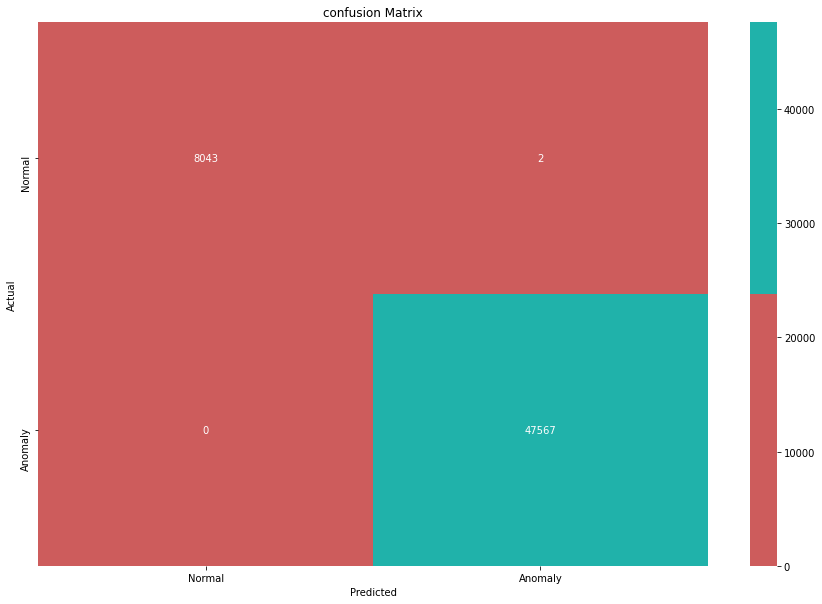

In [17]:
viz.drow_confusion_matrix(ytest.values,y_pred)

In [19]:
pickle.dump(ngb, open('./models/ngb.pkl', 'wb'))